# Q1 Sena İrem Toka 090190361

For this question I created a function to get the start and end of the novels which was specified in the text from the links and when I got the text from the links and tokenized them there were a lot of characters which were not space. So I had the clean the sentences using the re.sub.

In [1]:
import re
import nltk
import requests

nltk.download('punkt')

def clean_and_tokenize_novel(url):
    response = requests.get(url)

    if response.status_code == 200:
        novel_content = response.text

        start_match = re.search(r"\*\*\* START OF (THIS|THE) PROJECT GUTENBERG EBOOK [^\*]+\*\*\*", novel_content)
        end_match = re.search(r"\*\*\* END OF (THIS|THE) PROJECT GUTENBERG EBOOK [^\*]+\*\*\*", novel_content)

        if start_match and end_match:
            start = start_match.end()
            end = end_match.start()

            novel_text = novel_content[start:end]
            sentences = nltk.sent_tokenize(novel_text)
            cleaned_sentences = [re.sub(r'[^\w\s]+', '', sentence) for sentence in sentences]
            cleaned_sentences = [re.sub(r'\s+', ' ', sentence).strip() for sentence in cleaned_sentences]

            return cleaned_sentences

        else:
            print(f"Could not find start or end pattern for the novel in {url}")
            return None

    else:
        print(f"Failed to retrieve content from {url}. Status code: {response.status_code}")
        return None



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/senairemtoka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


I got each book separately using the function I had  

In [2]:
janeeyre_url = 'https://www.gutenberg.org/cache/epub/1260/pg1260.txt'
janeeyre_cleaned_sentences = clean_and_tokenize_novel(janeeyre_url)

print("Jane Eyre Cleaned Sentences:")
print(janeeyre_cleaned_sentences[:3])

Jane Eyre Cleaned Sentences:
['JANE EYRE AN AUTOBIOGRAPHY by Charlotte Brontë _ILLUSTRATED BY F H TOWNSEND_ London SERVICE PATON 5 HENRIETTA STREET 1897 _The Illustrations_ _in this Volume are the copyright of_ SERVICE PATON _London_ TO W M THACKERAY ESQ This Work IS RESPECTFULLY INSCRIBED BY THE AUTHOR PREFACE A preface to the first edition of Jane Eyre being unnecessary I gave none this second edition demands a few words both of acknowledgment and miscellaneous remark', 'My thanks are due in three quarters', 'To the Public for the indulgent ear it has inclined to a plain tale with few pretensions']


In [3]:
prideprejudice_url = 'https://www.gutenberg.org/cache/epub/1342/pg1342.txt'
prideprejudice_cleaned_sentences = clean_and_tokenize_novel(prideprejudice_url)
print("\nPride and Prejudice Cleaned Sentences:")
print(prideprejudice_cleaned_sentences[:3])


Pride and Prejudice Cleaned Sentences:
['Illustration GEORGE ALLEN PUBLISHER 156 CHARING CROSS ROAD LONDON RUSKIN HOUSE Illustration _Reading Janes Letters_ _Chap 34_ PRIDE', 'and PREJUDICE by Jane Austen with a Preface by George Saintsbury and Illustrations by Hugh Thomson Illustration 1894 Ruskin 156', 'Charing House']


I labeled each sentence in each book then put each of them in dataframes. 

In [4]:
import pandas as pd

austen_labels = [0] * len(prideprejudice_cleaned_sentences)
bronte_labels = [1] * len(janeeyre_cleaned_sentences)

austen_df = pd.DataFrame({'Sentence': prideprejudice_cleaned_sentences, 'Label': austen_labels})
bronte_df = pd.DataFrame({'Sentence': janeeyre_cleaned_sentences, 'Label': bronte_labels})

I merged the austen and bronte dataframes that contain the sentences and their labels. I merged them randomly so that they weren't merged in like one after the other.

In [5]:
merged_df = pd.concat([austen_df, bronte_df], ignore_index=True)
merged_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(merged_df.head())

                                            Sentence  Label
0  Her frantic joy at beholding me again moved me...      1
1         He begged pardon for having displeased her      0
2  Presently I stood within that clean bright kit...      1
3                       I shall be killed if Silence      1
4  Look at his wings said he he reminds me rather...      1


I imported the libraries I need to use the logistic regression methods. 

I vectorized and removed all the stop words from the merged dataframe.

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
vectorizer = CountVectorizer(stop_words='english')

X = vectorizer.fit_transform(merged_df['Sentence'])

I split the dataset to use the 25% of it as test data. I fitted the model to my train variables.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, merged_df['Label'], test_size=0.25, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

By using the test set I created the prediction from the model and got the accuracy

In [8]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)


I created the confusion matrix.

The model turned out to be 86% accurate.

In [9]:
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.86

Confusion Matrix:
[[ 924  282]
 [ 130 1574]]


# Q2


In [10]:
import os
import librosa
import librosa.display
from librosa.util import fix_length

import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Firstly I downloaded the voice data from the website we were given. It had 72 different folders and in each folder there were numerous .wav files. So to be able to get each of the audio files I had to access them in a way that I could get every single one of them. I had chatgpt's help in how to access the folders and the wav files in each folder.

It iterates through each audio file and loads the audio file using librosa, extracts features using mean and standard deviation of mfccs and labels each file with an individual identifier.


In [11]:
data_folder = '/Users/senairemtoka/Downloads/AXIOM audio'
individuals_data = []
labels = []
for i in range(1, 73):
    individual_folder = os.path.join(data_folder, f"{i:03d}")

    individual_features = []
    individual_labels = []

    for filename in os.listdir(individual_folder):
        if filename.endswith(".wav"):
            filepath = os.path.join(individual_folder, filename)

            audio_data, sr = librosa.load(filepath, sr=None)

            mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)
            features = np.hstack([np.mean(mfccs, axis=1), np.std(mfccs, axis=1)])

            individual_features.append(features)
            individual_labels.append(i)  

    individuals_data.extend(individual_features)
    labels.extend(individual_labels)


In [12]:
print("Shape of audio data:", audio_data.shape)

Shape of audio data: (20458,)


In [13]:
print("Sampling rate:", sr)

Sampling rate: 16000


I printed the shape and sampling rate and the audio waveform

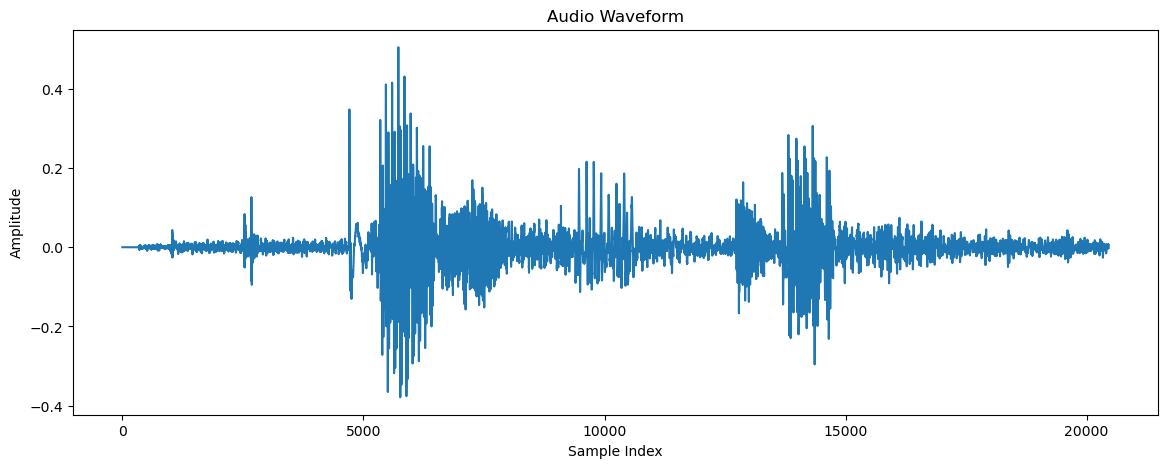

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(audio_data)
plt.title("Audio Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

I decided to use Random Forest Classifier as a machine learning algorithm it seemed like a good choice to identify each individual to me. 

I imported the needed libraries 

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


I created a dataframe to use in the model and split my data to test and training sets. I used 20% of the data as test set. I fitted the Random Forest Classifier model. The accuracy may increase or decrease by changing n_estimators=50 and random_state=42 values. 

In [16]:
df = pd.DataFrame(individuals_data)
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

I got the predictions by using the X test set and the accuracy came out to be almost 78%

In [17]:
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.778393351800554


I created the confusion matrix as a graph plot. I could not understand why 70th 71st 72nd individuals came out empty. I think this model was fairly good in predicting.

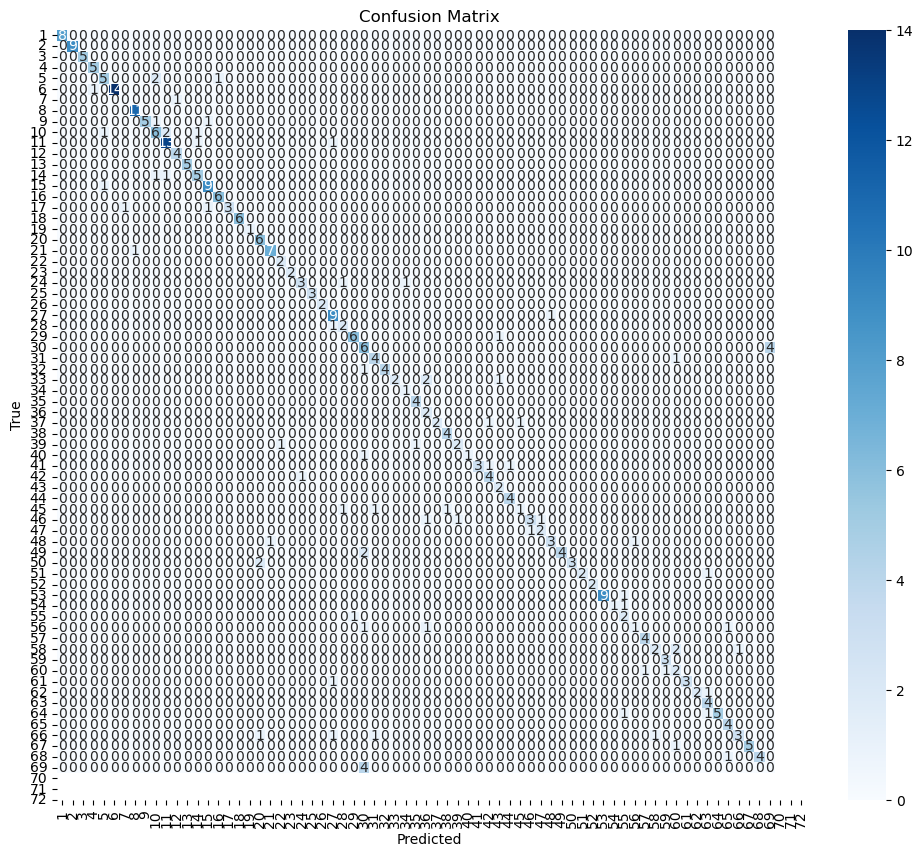

In [18]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=range(1, 73), yticklabels=range(1, 73))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


I used the SVC (Support Vector Classification) class in scikit-learn and I also scaled the train and test variables to get a better accuracy and it gave me a better outcome than the random classifier.

In [19]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = SVC()
model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)


accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')



Accuracy: 0.850415512465374


In [20]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Q3


I imported the airports and routes data into python. I got the column names from the website and wrote it myself otherwise it didn't import correctly.

In [21]:
import pandas as pd

url = 'https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat'

df_airports = pd.read_csv(url, header=None, names=["Airport ID", "City", "Country", "IATA", "ICAO", "Latitude", "Longitude", "Altitude","Timezone","DST","Tz database timezone","Type","Source"])

df_airports


Airport ID          City  \
1                                   Goroka Airport        Goroka   
2                                   Madang Airport        Madang   
3                     Mount Hagen Kagamuga Airport   Mount Hagen   
4                                   Nadzab Airport        Nadzab   
5      Port Moresby Jacksons International Airport  Port Moresby   
...                                            ...           ...   
14106                          Rogachyovo Air Base        Belaya   
14107                        Ulan-Ude East Airport      Ulan Ude   
14108                         Krechevitsy Air Base      Novgorod   
14109                  Desierto de Atacama Airport       Copiapo   
14110                           Melitopol Air Base     Melitopol   

                Country IATA  ICAO   Latitude   Longitude  Altitude Timezone  \
1      Papua New Guinea  GKA  AYGA  -6.081690  145.391998      5282       10   
2      Papua New Guinea  MAG  AYMD  -5.207080  145.789001        20       10   
3      Papua New Guinea  HGU  AYMH  -5.826790  144.296005      5388       10   
4      Papua New Guinea  LAE  AYNZ  -6.569803  146.725977       239       10   
5      Papua New Guinea  POM  AYPY  -9.443380  147.220001       146       10   
...                 ...  ...   ...        ...         ...       ...      ...   
14106            Russia   \N  ULDA  71.616699   52.478298       272       \N   
14107            Russia   \N  XIUW  51.849998  107.737999      1670       \N   
14108            Russia   \N  ULLK  58.625000   31.385000        85       \N   
14109             Chile  CPO  SCAT -27.261200  -70.779198       670       \N   
14110           Ukraine   \N  UKDM  46.880001   35.305000         0       \N   

      DST  Tz database timezone     Type       Source  
1       U  Pacific/Port_Moresby  airport  OurAirports  
2       U  Pacific/Port_Moresby  airport  OurAirports  
3       U  Pacific/Port_Moresby  airport  OurAirports  
4       U  Pacific/Port_Moresby  airport  OurAirports  
5       U  Pacific/Port_Moresby  airport  OurAirports  
...    ..                   ...      ...          ...  
14106  \N                    \N  airport  OurAirports  
14107  \N                    \N  airport  OurAirports  
14108  \N                    \N  airport  OurAirports  
14109  \N                    \N  airport  OurAirports  
14110  \N                    \N  airport  OurAirports  

[7698 rows x 13 columns]

In [22]:
import pandas as pd

url = 'https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat'


df_routes = pd.read_csv(url, header=None, names=["Airline", "Airline ID", "Source airport", "Source airport ID", "Destination airport", "Destination airport ID", "Codeshare", "Stops","Equipment"])

df_routes

Airline Airline ID Source airport Source airport ID Destination airport  \
0          2B        410            AER              2965                 KZN   
1          2B        410            ASF              2966                 KZN   
2          2B        410            ASF              2966                 MRV   
3          2B        410            CEK              2968                 KZN   
4          2B        410            CEK              2968                 OVB   
...       ...        ...            ...               ...                 ...   
67658      ZL       4178            WYA              6334                 ADL   
67659      ZM      19016            DME              4029                 FRU   
67660      ZM      19016            FRU              2912                 DME   
67661      ZM      19016            FRU              2912                 OSS   
67662      ZM      19016            OSS              2913                 FRU   

      Destination airport ID Codeshare  Stops Equipment  
0                       2990       NaN      0       CR2  
1                       2990       NaN      0       CR2  
2                       2962       NaN      0       CR2  
3                       2990       NaN      0       CR2  
4                       4078       NaN      0       CR2  
...                      ...       ...    ...       ...  
67658                   3341       NaN      0       SF3  
67659                   2912       NaN      0       734  
67660                   4029       NaN      0       734  
67661                   2913       NaN      0       734  
67662                   2912       NaN      0       734  

[67663 rows x 9 columns]


I merged the route and airport data so I have the source and target airports, full airport names and cities and renamed the columns so there would be no confusion and I dropped the airport codes.

In [23]:
import pandas as pd
merged_df = pd.merge(df_routes, df_airports, left_on="Source airport", right_on="IATA", how="left")

merged_df = merged_df.rename(columns={
    "Name": "Source_Airport_Name",
    "City": "Source_City",
    "Country": "Source_Country",
    "Latitude": "Source_Latitude",
    "Longitude": "Source_Longitude",
    "Altitude": "Source_Altitude",
    "Timezone": "Source_Timezone",
    "DST": "Source_DST",
    "Tz database timezone": "Source_Tz",
    "Type": "Source_Type",
    "Source": "Source_Source"
})

merged_df = pd.merge(merged_df, df_airports, left_on="Destination airport", right_on="IATA", how="left")

merged_df = merged_df.rename(columns={
    "Name": "Destination_Airport_Name",
    "City": "Destination_City",
    "Country": "Destination_Country",
    "Latitude": "Destination_Latitude",
    "Longitude": "Destination_Longitude",
    "Altitude": "Destination_Altitude",
    "Timezone": "Destination_Timezone",
    "DST": "Destination_DST",
    "Tz database timezone": "Destination_Tz",
    "Type": "Destination_Type",
    "Source": "Destination_Source"
})

merged_df = merged_df.drop(columns=["IATA_x", "IATA_y"])

merged_df

Airline Airline ID Source airport Source airport ID Destination airport  \
0          2B        410            AER              2965                 KZN   
1          2B        410            ASF              2966                 KZN   
2          2B        410            ASF              2966                 MRV   
3          2B        410            CEK              2968                 KZN   
4          2B        410            CEK              2968                 OVB   
...       ...        ...            ...               ...                 ...   
67658      ZL       4178            WYA              6334                 ADL   
67659      ZM      19016            DME              4029                 FRU   
67660      ZM      19016            FRU              2912                 DME   
67661      ZM      19016            FRU              2912                 OSS   
67662      ZM      19016            OSS              2913                 FRU   

      Destination airport ID Codeshare  Stops Equipment  \
0                       2990       NaN      0       CR2   
1                       2990       NaN      0       CR2   
2                       2962       NaN      0       CR2   
3                       2990       NaN      0       CR2   
4                       4078       NaN      0       CR2   
...                      ...       ...    ...       ...   
67658                   3341       NaN      0       SF3   
67659                   2912       NaN      0       734   
67660                   4029       NaN      0       734   
67661                   2913       NaN      0       734   
67662                   2912       NaN      0       734   

                           Airport ID_x  ... Destination_Country ICAO_y  \
0           Sochi International Airport  ...              Russia   UWKD   
1                     Astrakhan Airport  ...              Russia   UWKD   
2                     Astrakhan Airport  ...              Russia   URMM   
3         Chelyabinsk Balandino Airport  ...              Russia   UWKD   
4         Chelyabinsk Balandino Airport  ...              Russia   UNNT   
...                                 ...  ...                 ...    ...   
67658                   Whyalla Airport  ...           Australia   YPAD   
67659  Domodedovo International Airport  ...          Kyrgyzstan   UAFM   
67660       Manas International Airport  ...              Russia   UUDD   
67661       Manas International Airport  ...          Kyrgyzstan   UAFO   
67662                       Osh Airport  ...          Kyrgyzstan   UAFM   

      Destination_Latitude  Destination_Longitude  Destination_Altitude  \
0                55.606201              49.278702                 411.0   
1                55.606201              49.278702                 411.0   
2                44.225101              43.081902                1054.0   
3                55.606201              49.278702                 411.0   
4                55.012600              82.650703                 365.0   
...                    ...                    ...                   ...   
67658           -34.945000             138.531006                  20.0   
67659            43.061298              74.477600                2058.0   
67660            55.408798              37.906300                 588.0   
67661            40.609001              72.793297                2927.0   
67662            43.061298              74.477600                2058.0   

       Destination_Timezone Destination_DST      Destination_Tz  \
0                         3               N       Europe/Moscow   
1                         3               N       Europe/Moscow   
2                         3               N       Europe/Moscow   
3                         3               N       Europe/Moscow   
4                         7               N    Asia/Krasnoyarsk   
...                     ...             ...                 ...   
67658                   9.5               O  Australi

I created a graph for the routes and visualized it with gravis.

In [24]:
import networkx as nx
import gravis as gv
import numpy as np
import pandas as pd
G = nx.Graph()

for index, row in merged_df.iterrows():
    source_city = row['Source_City']
    destination_city = row['Destination_City']
    
    G.add_edge(source_city, destination_city)

In [25]:
gv.vis(G)

To find the minimal stops route I used an existent nx.shortest_path method which uses the dijkstra's algorithm

In [26]:
def find_minimal_stops_route(graph, source, target):
    try:
        minimal_stops_route = nx.shortest_path(graph, source=source, target=target, weight=None)
        return minimal_stops_route
    except nx.NetworkXNoPath:
        return None  

In [27]:
routes = [
    ('Antalya', 'Deer Lake'),
    ('Adana', 'Auckland'),
    ('Ankara', 'Kona'),
    ('Sydney', 'Churchill')
]

I found the minimal stops routes for the cities given in the question 

In [28]:
for source, target in routes:
    minimal_stops_route = find_minimal_stops_route(G, source, target)
    if minimal_stops_route is not None:
        print(f"Minimal stops route from {source} to {target}: {minimal_stops_route}")
    else:
        print(f"No route found from {source} to {target}")

Minimal stops route from Antalya to Deer Lake: ['Antalya', 'London', 'Halifax', 'Deer Lake']
Minimal stops route from Adana to Auckland: ['Adana', 'Istanbul', 'Guangzhou', 'Auckland']
Minimal stops route from Ankara to Kona: ['Ankara', 'Duesseldorf', 'Los Angeles', 'Kona']
Minimal stops route from Sydney to Churchill: ['Sydney', 'Vancouver', 'Winnipeg', 'Churchill']


I used the pagerank and sorted the cities and found the 10 most important cities. nan values came out the most but other than that the most are as below. 

In [29]:
pagerank_scores = nx.pagerank(G)
sorted_cities = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)

In [30]:
print("Top 10 cities that are important for the global flight network are:")
for city, score in sorted_cities[:11]:
    print(f"{city}: {score}")

Top 10 cities that are important for the global flight network are:
nan: 0.006955623818968829
London: 0.00633053120416132
Moscow: 0.006204371126299998
Paris: 0.005596653535740495
Istanbul: 0.0053611323631530105
Atlanta: 0.004669270965577445
Chicago: 0.004593982084455671
Beijing: 0.004475223577912518
Denver: 0.004442749644696046
Dallas-Fort Worth: 0.004413872007560219
Amsterdam: 0.004327880509671642


# Q4

I downloaded the files **title.basics.tsv.gz, name.basics.tsv.gz, title.principals.tsv.gz** from the provided website. I imported them into jupyter notebook by only the columns I needed because otherwise it was taking too much time as the files are fairly large. 

In [31]:
import pandas as pd

principals_file_path = '/Users/senairemtoka/Downloads/title.principals.tsv'

columns_to_read = ['tconst', 'nconst', 'category']

principals_df = pd.read_csv(principals_file_path, delimiter='\t', usecols=columns_to_read)

print(principals_df.head())

      tconst     nconst         category
0  tt0000001  nm1588970             self
1  tt0000001  nm0005690         director
2  tt0000001  nm0374658  cinematographer
3  tt0000002  nm0721526         director
4  tt0000002  nm1335271         composer


In [32]:
basics_file_path = '/Users/senairemtoka/Downloads/title.basics.tsv'

columns_to_read = ['tconst','titleType','primaryTitle']

basics_df = pd.read_csv(basics_file_path, delimiter='\t', usecols=columns_to_read)

print(basics_df.head())

      tconst titleType            primaryTitle
0  tt0000001     short              Carmencita
1  tt0000002     short  Le clown et ses chiens
2  tt0000003     short          Pauvre Pierrot
3  tt0000004     short             Un bon bock
4  tt0000005     short        Blacksmith Scene


In [33]:
names_file_path = '/Users/senairemtoka/Downloads/name.basics.tsv'

columns_to_read = ['nconst','primaryName']

names_df = pd.read_csv(names_file_path, delimiter='\t', usecols=columns_to_read)

print(names_df.head())

      nconst      primaryName
0  nm0000001     Fred Astaire
1  nm0000002    Lauren Bacall
2  nm0000003  Brigitte Bardot
3  nm0000004     John Belushi
4  nm0000005   Ingmar Bergman


I needed to merge these 3 dataframes by some rules so first I only got the people who are actors or actresses. Then I merged the actors dataframe with the basics_df by the title of the project. And finally i merged that dataframe with the names of the actors by nconst. 

In [34]:
actors_df = principals_df[principals_df['category'].isin(['actor', 'actress'])]
actors_df

tconst      nconst category
11        tt0000005   nm0443482    actor
12        tt0000005   nm0653042    actor
16        tt0000007   nm0179163    actor
17        tt0000007   nm0183947    actor
21        tt0000008   nm0653028    actor
...             ...         ...      ...
59600070  tt9916856  nm10538647  actress
59600075  tt9916880   nm2784764  actress
59600076  tt9916880   nm1483166    actor
59600077  tt9916880   nm0254176  actress
59600078  tt9916880   nm0286175    actor

[23440665 rows x 3 columns]

In [35]:
merged_df = pd.merge(actors_df, basics_df, on='tconst')
merged_df

tconst      nconst category  titleType  \
0         tt0000005   nm0443482    actor      short   
1         tt0000005   nm0653042    actor      short   
2         tt0000007   nm0179163    actor      short   
3         tt0000007   nm0183947    actor      short   
4         tt0000008   nm0653028    actor      short   
...             ...         ...      ...        ...   
23440456  tt9916856  nm10538647  actress      short   
23440457  tt9916880   nm2784764  actress  tvEpisode   
23440458  tt9916880   nm1483166    actor  tvEpisode   
23440459  tt9916880   nm0254176  actress  tvEpisode   
23440460  tt9916880   nm0286175    actor  tvEpisode   

                                         primaryTitle  
0                                    Blacksmith Scene  
1                                    Blacksmith Scene  
2         Corbett and Courtney Before the Kinetograph  
3         Corbett and Courtney Before the Kinetograph  
4              Edison Kinetoscopic Record of a Sneeze  
...                                               ...  
23440456                                     The Wind  
23440457                    Horrid Henry Knows It All  
23440458                    Horrid Henry Knows It All  
23440459                    Horrid Henry Knows It All  
23440460                    Horrid Henry Knows It All  

[23440461 rows x 5 columns]

In [36]:
final_df = pd.merge(merged_df, names_df, on='nconst')
final_df

tconst      nconst category titleType  \
0         tt0000005   nm0443482    actor     short   
1         tt0000005   nm0653042    actor     short   
2         tt0000007   nm0179163    actor     short   
3         tt0003116   nm0179163    actor     movie   
4         tt0003730   nm0179163    actor     movie   
...             ...         ...      ...       ...   
23440454  tt9916756  nm10781824  actress     short   
23440455  tt9916764  nm10538641    actor     short   
23440456  tt9916856  nm10538650  actress     short   
23440457  tt9916856  nm10538646    actor     short   
23440458  tt9916856  nm10538647  actress     short   

                                         primaryTitle       primaryName  
0                                    Blacksmith Scene    Charles Kayser  
1                                    Blacksmith Scene          John Ott  
2         Corbett and Courtney Before the Kinetograph  James J. Corbett  
3                        The Man from the Golden West  James J. Corbett  
4                            The Burglar and the Lady  James J. Corbett  
...                                               ...               ...  
23440454                     Pretty Pretty Black Girl   Lakeisha Barnes  
23440455                                           38      Yvonne Akins  
23440456                                     The Wind     Anna Fitoussi  
23440457                                     The Wind    Andreas Demmel  
23440458                                     The Wind   Kathrin Knöpfle  

[23440459 rows x 6 columns]

In [37]:
import duckdb
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import gravis as gv

I decided to to this question with an sql query as we did in the class. So I looked at the examples that we did in the lecture notebook and created a query getting the columns I needed. I just needed to count how many times any pair of two actors took role in the same project. 

In [38]:

res = duckdb.sql("""
SELECT COUNT(*) AS count, a.primaryName AS Actor1, b.primaryName AS Actor2
FROM final_df a
JOIN final_df b ON a.tconst = b.tconst AND a.nconst < b.nconst
GROUP BY a.primaryName, b.primaryName
ORDER BY count DESC
""").to_df()
res


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

count            Actor1           Actor2
0          9988        Tito Sotto        Vic Sotto
1          9946         Vic Sotto     Joel de Leon
2          9946        Tito Sotto     Joel de Leon
3          8024      Pia Arcangel    Arnold Clavio
4          7934  Manuela do Monte  Giovanna Grigio
...         ...               ...              ...
17158089      1  Victor Averyanov   Yana Lyapunova
17158090      1   Keyanna Jackson  Shannon Crowell
17158091      1   Casey Al-Shaqsy    Nadia Johnson
17158092      1     Andrea Lehman       Aj Meadows
17158093      1       Ivan Greene        Nate Gold

[17158094 rows x 3 columns]

In the question it says that Haluk Bilginer and Bekir Aksoy appears in the same movie or tv episode 40 times. I thought maybe in 40 it didn't count them uniquely? However many tries I did I only got 20. In the query I also get every title type

In [39]:
actors_to_check = ["Haluk Bilginer", "Bekir Aksoy"]

duo_check = res[
    (res['Actor1'].isin(actors_to_check)) & (res['Actor2'].isin(actors_to_check))
]

# Count the number of pairs
pair_count = len(duo_check)

print(f"Number of pairs for {', '.join(actors_to_check)} in DataFrame: {pair_count}")
print(duo_check)


Number of pairs for Haluk Bilginer, Bekir Aksoy in DataFrame: 1
        count          Actor1       Actor2
279239     20  Haluk Bilginer  Bekir Aksoy


I created a graph from the actor pairs and assign the weight as however many times they appeared in a project together. Creating this graph takes a fairly long time so I didn't visualize it.

In [40]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

for index, row in res.iterrows():
    actor1 = row['Actor1']
    actor2 = row['Actor2']
    weight = row['count']

    if actor1 is not None and actor2 is not None:
        G.add_edge(actor1, actor2, weight=weight)

I created the actor pairs given in the question and used the nx.shortest_path to find the minimal connection in between each pair.

In [41]:
actor_pairs = [
   ('Charles Chaplin', 'Nur Sürer'),
    ('Paul Newman' , 'Keanu Reeves'),
    ('Vanessa Redgrave' , 'Tilda Swinton'),
    ('Harold Lloyd' , 'Zoe Kazan')
]

In [42]:
for actor1, actor2 in actor_pairs:
    try:
        shortest_path = nx.shortest_path(G, source=actor1, target=actor2)
        print(f"Shortest path between {actor1} and {actor2}: {shortest_path}")
    except nx.NetworkXNoPath:
        print(f"No path found between {actor1} and {actor2}")

Shortest path between Charles Chaplin and Nur Sürer: ['Charles Chaplin', 'Claire Bloom', 'Charles Dance', 'Tuba Büyüküstün', 'Nur Sürer']
Shortest path between Paul Newman and Keanu Reeves: ['Paul Newman', 'Bonnie Bedelia', 'Keanu Reeves']
Shortest path between Vanessa Redgrave and Tilda Swinton: ['Vanessa Redgrave', 'Jane Fonda', 'Tilda Swinton']
Shortest path between Harold Lloyd and Zoe Kazan: ['Harold Lloyd', 'James Fitzgerald', 'Zoe Kazan']


I used the eigen-value centrality included in the networkx to find the 10 actors that are important for the network

In [43]:
sorted(nx.eigenvector_centrality(G).items(), key=lambda item: -item[1])[:10]

[('Mr. Pete', 0.0781457285531054),
 ('Erik Everhard', 0.07465086117155438),
 ('Mick Blue', 0.07228730669527864),
 ('James Deen', 0.07198563731794203),
 ('Marco Banderas', 0.07104524266808476),
 ('Manuel Ferrara', 0.07069395115292976),
 ('Tommy Gunn', 0.06984128828017899),
 ('Billy Glide', 0.06904793646085906),
 ('John Strong', 0.06892017958969052),
 ('Mark Davis', 0.068785140716656)]

# Q5

I downloaded the json file from the given link and I wanted to turn it into a dataframe but since it was a dictionary I had to normalize it to get the columns correctly.

In [44]:
import json

file_path = '/Users/senairemtoka/Downloads/data.json'


with open(file_path, 'r') as file:
    data = json.load(file)


In [45]:
import pandas as pd
df = pd.DataFrame(data)
print(df.head())

                                               nodes
0  {'id': 11, 'name': 'Alfred E. Engelbrecht', 't...
1  {'id': 4, 'name': 'Charles Joseph Thorne', 'th...
2  {'id': 1, 'name': 'Ernest Willard Anderson', '...
3  {'id': 7, 'name': 'Carl Eric Langenhop', 'thes...
4  {'id': 6, 'name': 'William B. Stiles', 'thesis...


In [46]:
data_list = data

df = pd.DataFrame.from_records(data_list)
df

nodes
0       {'id': 11, 'name': 'Alfred E. Engelbrecht', 't...
1       {'id': 4, 'name': 'Charles Joseph Thorne', 'th...
2       {'id': 1, 'name': 'Ernest Willard Anderson', '...
3       {'id': 7, 'name': 'Carl Eric Langenhop', 'thes...
4       {'id': 6, 'name': 'William B. Stiles', 'thesis...
...                                                   ...
256764  {'id': 235561, 'name': 'Thomas Krabichler', 't...
256765  {'id': 164293, 'name': 'Akhil Datta-Gupta', 't...
256766  {'id': 235566, 'name': 'Raphael Sebastian Stei...
256767  {'id': 164294, 'name': 'Xianlin Ma', 'thesis':...
256768  {'id': 164297, 'name': 'Maksud Alisimran Dzhav...

[256769 rows x 1 columns]

In [47]:
normalized_df = pd.json_normalize(df['nodes'])
normalized_df

id                        name  \
0           11       Alfred E. Engelbrecht   
1            4       Charles Joseph Thorne   
2            1     Ernest Willard Anderson   
3            7         Carl Eric Langenhop   
4            6           William B. Stiles   
...        ...                         ...   
256764  235561           Thomas Krabichler   
256765  164293           Akhil Datta-Gupta   
256766  235566   Raphael Sebastian Steiner   
256767  164294                  Xianlin Ma   
256768  164297  Maksud Alisimran Dzhavadov   

                                                   thesis  \
0       Coupled Bending and Torsional Free Vibration o...   
1       The Approximate Solution of Linear Differentia...   
2       Statics of Special Types of Homogeneous Elasti...   
3       Properties of Kernels of Integral Equations Wh...   
4       Solutions of Clamped Plated Problems by Means ...   
...                                                   ...   
256764  Term structure modelling beyond classical para...   
256765                                               None   
256766  The Harmonic conjunction of automorphic forms ...   
256767  History matching and uncertainty quantificatio...   
256768                                               None   

                               school        country    year  \
0               Iowa State University   UnitedStates  1949.0   
1               Iowa State University   UnitedStates  1941.0   
2               Iowa State University   UnitedStates  1933.0   
3               Iowa State University   UnitedStates  1948.0   
4               Iowa State University   UnitedStates  1945.0   
...                               ...            ...     ...   
256764                     ETH Zürich    Switzerland  2017.0   
256765  University of Texas at Austin   UnitedStates  1992.0   
256766          University of Bristol  UnitedKingdom  2018.0   
256767           Texas A&M University   UnitedStates  2008.0   
256768                                          None     NaN   

                                  subject         advisors  \
0                                    None              [1]   
1                                    None            [239]   
2       74—Mechanics of deformable solids            [258]   
3                                    None            [281]   
4                                    None            [258]   
...                                   ...              ...   
256764                               None          [58878]   
256765                 76—Fluid mechanics          [45784]   
256766                   11—Number theory   [70403, 71607]   
256767                      62—Statistics  [38132, 164293]   
256768                        51—Geometry          [99692]   

                                      students  
0                                           []  
1                               [19930, 19939]  
2                                 [11, 28, 31]  
3       [48, 104689, 38, 33, 3026, 39, 32, 35]  
4                                           []  
...                                        ...  
256764                                      []  
256765                        [164294, 197043]  
256766                                      []  
256767                                      []  
256768                                      []  

[256769 rows x 9 columns]

Again, I used the sql queries to get the data as I wanted. I got each country and counted the number of students and advisors from each country and created the weights by counting the students. 

In [48]:
import pandas as pd
import duckdb
import networkx as nx

df1 = duckdb.sql("""
SELECT 
    a.country as advisor_country, 
    b.country as student_country, 
    COUNT(*) as weight
FROM (
    SELECT 
        a.id as a_id,
        a.country as country,
        unnest(a.advisors) as advisor_id
    FROM normalized_df a
) a
JOIN (
    SELECT 
        b.id as b_id,
        b.country as country,
        unnest(b.students) as student_id
    FROM normalized_df b
) b
ON a.advisor_id = b.student_id
GROUP BY 
    a.country, b.country

""").to_df()
df1


advisor_country student_country  weight
0             Israel          Israel     579
1          Australia          Canada      44
2      UnitedKingdom         Germany    1095
3            Germany     Switzerland     946
4             France           Spain      22
...              ...             ...     ...
1612         Armenia         Germany       3
1613          Canada           China       1
1614            None         Nigeria       2
1615          Canada          Mexico       1
1616        Colombia           China       1

[1617 rows x 3 columns]

I created the weighted graph and visualized it 

In [49]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


G = nx.Graph()

for index, row in df1.iterrows():
    advisor_country = row['advisor_country']
    student_country = row['student_country']
    weight = row['weight']

    if advisor_country is not None and student_country is not None:
        G.add_edge(advisor_country, student_country, weight=weight)
    else:
        pass



In [50]:
import gravis as gv
gv.vis(G)

I used the pagerank scores to find the top 10 countries

In [51]:
pagerank_scores = nx.pagerank(G)
sorted_cities = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)

In [52]:
print("Top 10 countries in mathematics globally:")
for city, score in sorted_cities[:11]:
    print(f"{city}: {score}")

Top 10 countries in mathematics globally:
UnitedStates: 0.31007386602197634
Germany: 0.1088346692358659
UnitedKingdom: 0.06362050699053853
France: 0.059947779109636244
Russia: 0.04796546854587929
Netherlands: 0.029262068147089117
Canada: 0.01913940001094538
Switzerland: 0.01891859741443063
Ukraine: 0.016789054987489366
Spain: 0.016782010943468016
Sweden: 0.01608231635141734


For this part I used the sql query again to get the universities of the students and the advisors and get the weights  


In [53]:
df2 = duckdb.sql("""
SELECT 
    a.school as advisor_university, 
    b.school as student_university, 
    COUNT(*) as weight
FROM (
    SELECT 
        a.id as a_id,
        a.school,
        unnest(a.advisors) as advisor_id
    FROM normalized_df a
) a
JOIN (
    SELECT 
        b.id as b_id,
        b.school,
        unnest(b.students) as student_id
    FROM normalized_df b
) b
ON a.advisor_id = b.student_id
GROUP BY 
    a.school, b.school
""").to_df()
df2

advisor_university  \
0                                       Universität Wien   
1      Rheinisch-Westfälische Technische Hochschule A...   
2      Rheinisch-Westfälische Technische Hochschule A...   
3                                  Iowa State University   
4                                                   None   
...                                                  ...   
30842          University of North Carolina at Charlotte   
30843                          University of Mississippi   
30844                      University of New South Wales   
30845                             University of Zimbabwe   
30846                     National Chiao Tung University   

                        student_university  weight  
0                                     None     247  
1           Humboldt-Universität zu Berlin       1  
2               Universiteit van Amsterdam      13  
3                   University of Michigan      64  
4      Friedrich-Schiller-Universität Jena      92  
...                                    ...     ...  
30842                  Tel Aviv University       1  
30843             University of Notre Dame       2  
30844             University of Cincinnati       6  
30845                                            1  
30846  University of Maryland College Park       5  

[30847 rows x 3 columns]

I created the graph and visualized it 

In [54]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


G = nx.Graph()

for index, row in df2.iterrows():
    advisor_university = row['advisor_university']
    student_university = row['student_university']
    weight = row['weight']

    if advisor_university is not None and student_university is not None:
        G.add_edge(advisor_university, student_university, weight=weight)
    else:
        pass


In [55]:
import gravis as gv
gv.vis(G)

In [56]:
pagerank_scores = nx.pagerank(G)
sorted_cities = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)

there were nan values the most so i got the 10 universites after that

In [57]:
print("Top 10 universities in mathematics globally:")
for city, score in sorted_cities[:11]:
    print(f"{city}: {score}")

Top 10 universities in mathematics globally:
: 0.02548789402178124
Princeton University: 0.02039076858750425
University of California, Berkeley: 0.020095513018987467
Harvard University: 0.019199217996021662
Massachusetts Institute of Technology: 0.01867593639452714
Lomonosov Moscow State University: 0.018560617073402896
University of Cambridge: 0.01695841749702902
Stanford University: 0.015580330720535773
The University of Chicago: 0.013870610566985414
Université de Paris: 0.010345227620669823
Columbia University: 0.009389553733659498


With the sql query I got all the subjects and counted each student in that subject and school.

In [58]:

df4 = duckdb.sql("""
SELECT 
    school,
    thesis,
    subject,
    COUNT(DISTINCT student) AS student_count
FROM (
    SELECT 
        school,
        thesis,
        subject,
        UNNEST(students) AS student
    FROM normalized_df
) AS subquery
GROUP BY school, thesis, subject
""").to_df()
df4

school  \
0      Technion-Israel Institute of Technology   
1            Lomonosov Moscow State University   
2           University of California, Berkeley   
3           California Institute of Technology   
4                       Uniwersytet Warszawski   
...                                        ...   
49742                                     None   
49743                        McGill University   
49744                      Stanford University   
49745                    University of Florida   
49746                        Purdue University   

                                                  thesis  \
0                                                   None   
1      Ergodicity, Continuity and Analyticity of Rand...   
2      Quantum Gromov-Hausdorff Distance and Continui...   
3      I. Extended Applications of the Hotwire Anemom...   
4      Un continu dont tout sous-continu est indécomp...   
...                                                  ...   
49742  Adsorptionsuntersuchungen an spektralreinem Pl...   
49743  Physical Processes Associated with Variability...   
49744  I/O Characterization and Attribute Caches for ...   
49745    Tests of Misspecification for Parametric Models   
49746  Exploring Dirichlet Mixture and Logistic Gauss...   

                                              subject  student_count  
0                                    05—Combinatorics              2  
1      60—Probability theory and stochastic processes             10  
2                              46—Functional analysis              5  
3                                                None             10  
4                                 54—General topology              8  
...                                               ...            ...  
49742               78—Optics, electromagnetic theory              1  
49743                                   86—Geophysics              1  
49744                                            None              1  
49745                                   62—Statistics              1  
49746                                   62—Statistics              1  

[49747 rows x 4 columns]

I created the graph from the query I got and visualized it.

In [59]:
G = nx.Graph()

for index, row in df4.iterrows():
    school = row['school']
    subject = row['subject']
    weight = row['student_count']

    if school is not None and subject is not None:
        G.add_edge(school, subject, weight=weight)
    else:
        pass        

In [60]:
import gravis as gv
gv.vis(G)

With the function i create weighted graphs for the subject that's sent into the function then find the degree centrality then return the top 10 universities.

In [61]:
import pandas as pd
import networkx as nx

def top_universities_by_subject(df, subject, top_n=10):
    subject_df = df[~df['subject'].isna() & df['subject'].str.contains(subject, case=False)]

    G_universities = nx.Graph()

    for _, row in subject_df.iterrows():
        school = row['school']
        thesis = row['thesis']
        student_count = row['student_count']

        if school is not None and thesis is not None:
            G_universities.add_edge(school, thesis, weight=student_count)

    degree_centrality = nx.degree_centrality(G_universities)
    top_universities = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:top_n]

    return top_universities


In [62]:
subject = 'Statistics'
top_universities = top_universities_by_subject(df4, subject)
print(f"Top 10 universities for {subject}:")
print(top_universities)

Top 10 universities for Statistics:
['Stanford University', 'University of Washington', 'University of California, Berkeley', 'Harvard University', 'University of Wisconsin-Madison', 'University of Michigan', 'University of Minnesota-Minneapolis', 'The University of Chicago', 'University of California, Los Angeles', 'Purdue University']


In [63]:
subject = 'Group theory'
top_universities = top_universities_by_subject(df4, subject)
print(f"Top 10 universities for {subject}:")
print(top_universities)


Top 10 universities for Group theory:
['University of London', 'University of Cambridge', 'Ferdowsi University of Mashhad', 'Australian National University', 'Lomonosov Moscow State University', 'Victoria University of Manchester', 'Ural State University', 'Universidad de Zaragoza', 'University of Birmingham', 'University of St. Andrews']


In [64]:
subject = 'Topology'
top_universities = top_universities_by_subject(df4, subject)
print(f"Top 10 universities for {subject}:")
print(top_universities)


Top 10 universities for Topology:
['University of Texas at Austin', 'Lomonosov Moscow State University', 'Universidade de São Paulo', 'Uniwersytet Warszawski', 'University of Oxford', 'Massachusetts Institute of Technology', 'Shahid Chamran University of Ahvaz', 'Universidad Complutense de Madrid', 'Rheinische Friedrich-Wilhelms-Universität Bonn', 'University of Cambridge']


In [65]:
subject = 'Functional Analysis'
top_universities = top_universities_by_subject(df4, subject)
print(f"Top 10 universities for {subject}:")
print(top_universities)


Top 10 universities for Functional Analysis:
['Universitat de València', 'Voronezh State University', 'Lomonosov Moscow State University', 'Universidad de Granada', 'Universidad Complutense de Madrid', 'University of Cambridge', '', 'Universidad de Sevilla', 'Université Bordeaux 1', 'University of California, Berkeley']
